In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [87]:
!pip install --upgrade cmdstanpy
!pip install prophet


In [88]:
import prophet

In [89]:
from google.colab import files
uploaded = files.upload()


Saving Traffic data.csv to Traffic data (1).csv


In [90]:
df = pd.read_csv('Traffic data.csv')
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [91]:
df.isnull().sum()

,0
ID,0
Datetime,0
Count,0


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


In [93]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        18288 non-null  int64         
 1   Datetime  18288 non-null  datetime64[ns]
 2   Count     18288 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 428.8 KB


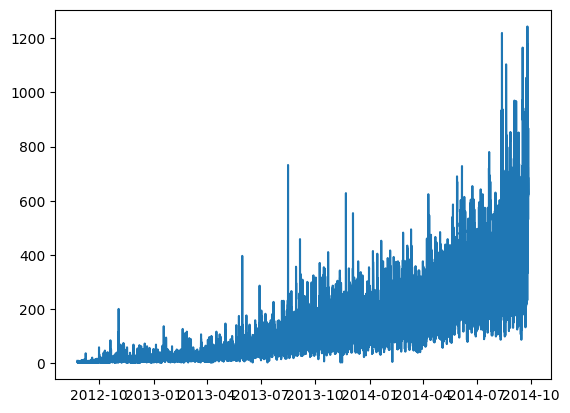

In [94]:
plt.plot(df['Datetime'], df['Count'])
plt.show()

Format data for the model

In [95]:
df.index = df['Datetime']
df['y'] = df['Count']
df.drop(['ID','Datetime', 'Count'], axis=1, inplace=True)
df.head()

,y
Datetime,
2012-08-25 00:00:00,8
2012-08-25 01:00:00,2
2012-08-25 02:00:00,6
2012-08-25 03:00:00,2
2012-08-25 04:00:00,2


Aggregating data by day: grouping entries by date (ignoring time) and summing values for each day

In [96]:
df = df.resample('D').sum()
df.head()

,y
Datetime,
2012-08-25,76
2012-08-26,88
2012-08-27,62
2012-08-28,58
2012-08-29,60


In [97]:
df['ds'] = df.index
df.head()

,y,ds
Datetime,,
2012-08-25,76,2012-08-25
2012-08-26,88,2012-08-26
2012-08-27,62,2012-08-27
2012-08-28,58,2012-08-28
2012-08-29,60,2012-08-29


In [98]:
size = 0.8
train = df[:int(size*len(df))]
test = df[int(size*len(df)):]

In [99]:
model = prophet.Prophet(yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode='additive',
    seasonality_prior_scale=10,
    changepoint_prior_scale=0.9)
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0euk2v80/y8n04emt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0euk2v80/eobiy3go.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65387', 'data', 'file=/tmp/tmp0euk2v80/y8n04emt.json', 'init=/tmp/tmp0euk2v80/eobiy3go.json', 'output', 'file=/tmp/tmp0euk2v80/prophet_model71ektlj5/prophet_model-20250423171709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:17:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [100]:
future = model.make_future_dataframe(periods=len(test), freq='D')

In [101]:
forecast = model.predict(future)

In [102]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-08-25,-392.879678,-1434.911909,128.158974,-392.879678,-392.879678,-272.135828,-272.135828,-272.135828,-677.316728,-677.316728,-677.316728,405.180900,405.180900,405.180900,0.0,0.0,0.0,-665.015506
1,2012-08-26,-386.660038,-1627.297695,-20.722070,-386.660038,-386.660038,-367.052534,-367.052534,-367.052534,-775.734934,-775.734934,-775.734934,408.682400,408.682400,408.682400,0.0,0.0,0.0,-753.712572
2,2012-08-27,-380.440398,-427.337880,1180.947112,-380.440398,-380.440398,748.379654,748.379654,748.379654,336.608880,336.608880,336.608880,411.770774,411.770774,411.770774,0.0,0.0,0.0,367.939256
3,2012-08-28,-374.220758,-329.840459,1294.970495,-374.220758,-374.220758,789.688283,789.688283,789.688283,375.201434,375.201434,375.201434,414.486848,414.486848,414.486848,0.0,0.0,0.0,415.467525
4,2012-08-29,-368.001117,-506.759334,1120.151047,-368.001117,-368.001117,706.002577,706.002577,706.002577,289.150837,289.150837,289.150837,416.851740,416.851740,416.851740,0.0,0.0,0.0,338.001460




**trend**: General trend of the data without seasonal effects.

**yhat_lower / yhat_upper**: Confidence interval for the predicted value.

**trend_lower / trend_upper**: Confidence interval for the trend.

**additive_terms / additive_terms_lower / additive_terms_upper**: Additive effects and their confidence interval (influence of seasonal or other factors).

**weekly / weekly_lower / weekly_upper**: Weekly seasonality and its confidence intervals (traffic variation depending on the days of the week).

**yearly / yearly_lower / yearly_upper**: Annual seasonality and its confidence intervals (traffic variation depending on the seasons).

**multiplicative_terms / multiplicative_terms_lower / multiplicative_terms_upper**: Multiplicative effects, which adjust the predictions proportionally.

**yhat**: Final predicted value, i.e., the estimated number of vehicles for each day.


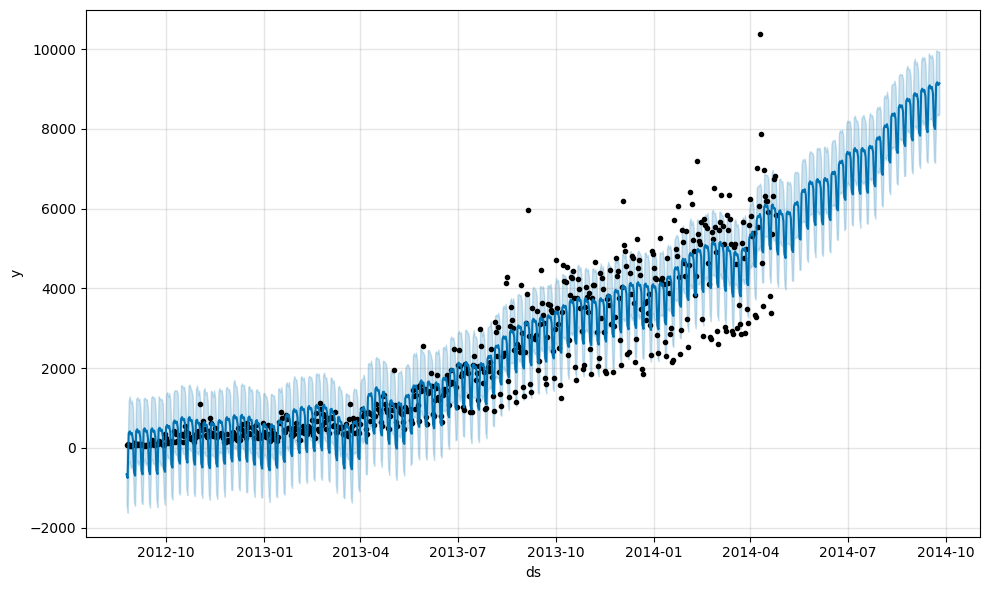

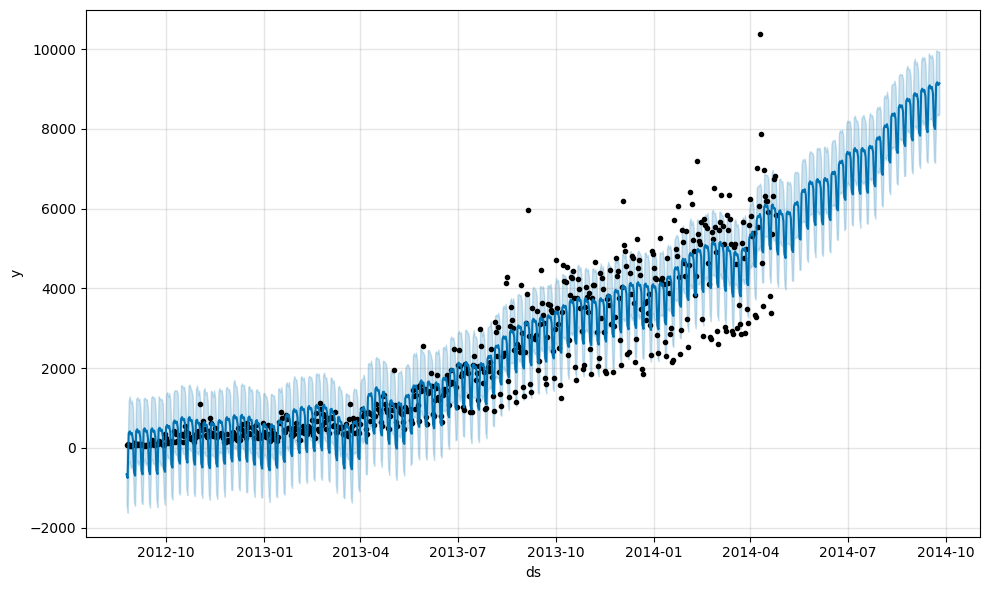

In [103]:
model.plot(forecast)

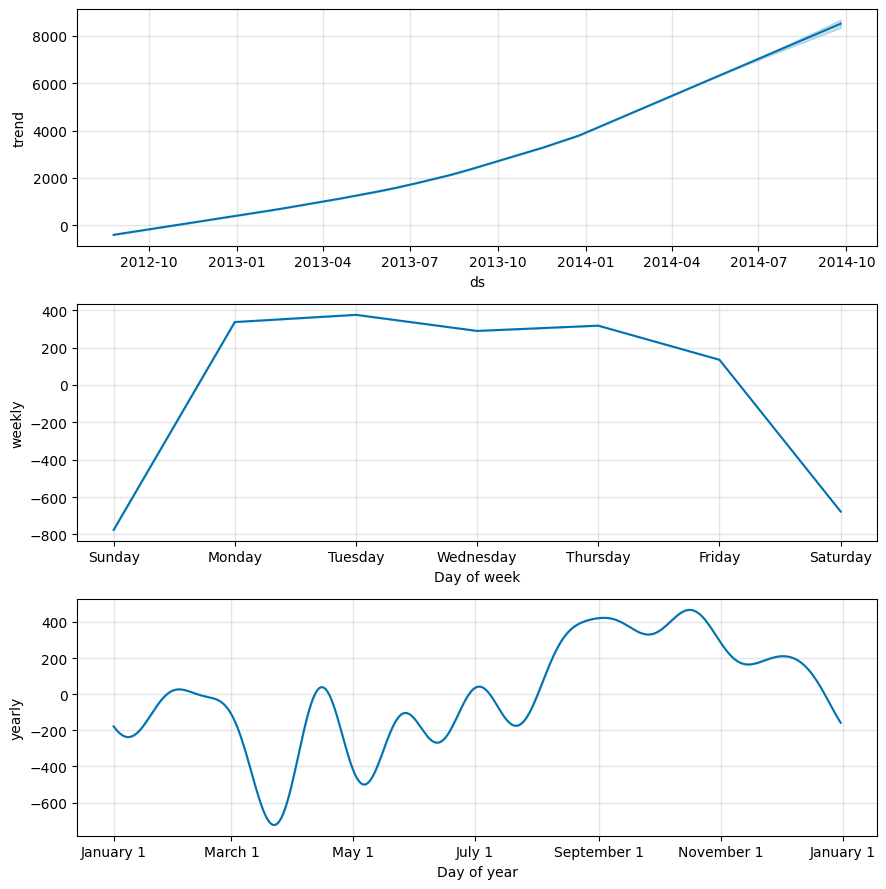

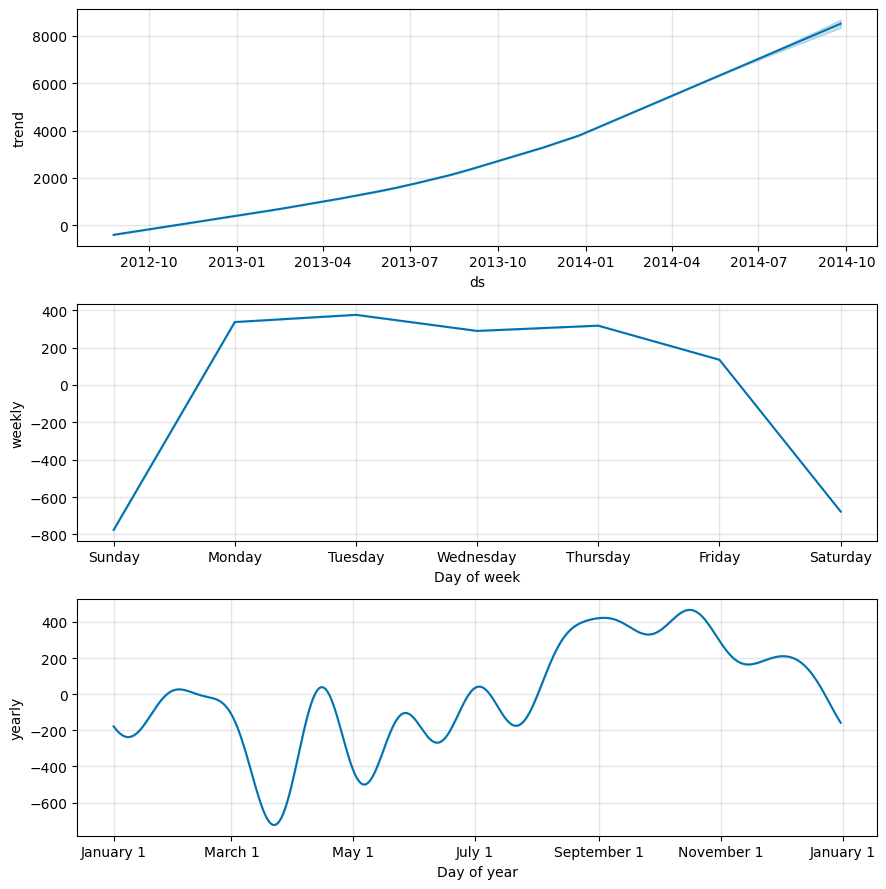

In [104]:
model.plot_components(forecast)

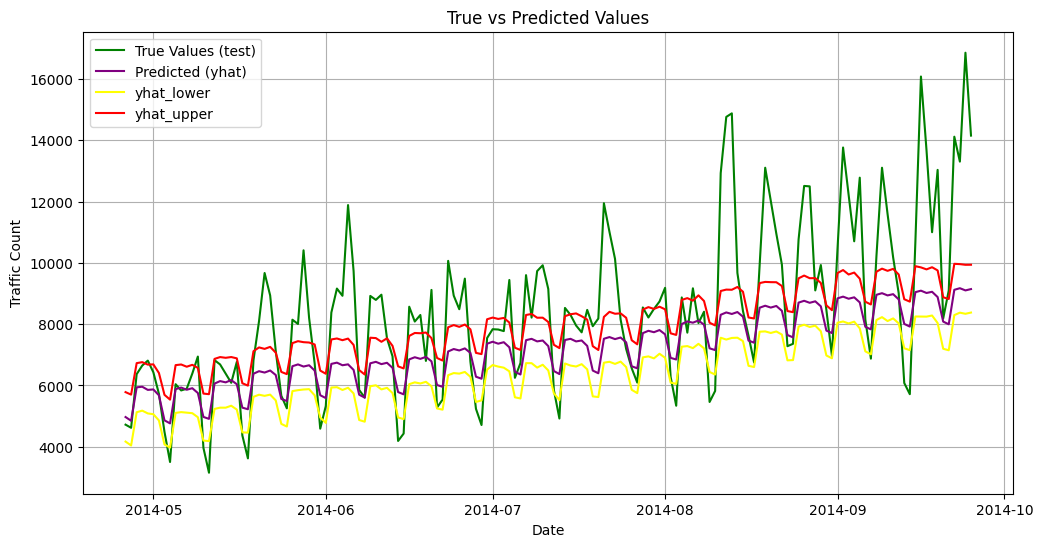

In [105]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['y'], label='True Values (test)', color='green')
plt.plot(forecast.set_index('ds').loc[test.index]['yhat'], label='Predicted (yhat)', color='purple')
plt.plot(forecast.set_index('ds').loc[test.index]['yhat_lower'], label='yhat_lower', color='yellow')
plt.plot(forecast.set_index('ds').loc[test.index]['yhat_upper'], label='yhat_upper', color='red')
plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Traffic Count')
plt.legend()
plt.grid(True)
plt.show()

In [106]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = forecast['yhat'][-len(test):].values
y_true = test['y'].values
MAE = mean_absolute_error(y_true, y_pred)
RMSE = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'MAE: {MAE}')
print(f'RMSE: {RMSE}')


MAE: 1595.0295394397413
RMSE: 2218.409816326115


**MAE** : Mean Absolute Error

which is equal to 1595

--> Interpretation: On average, the model is off by 1595 vehicules per day.

**RMSE** : Root Mean Squared Error

which is equal to 2218

--> Interpretation:
he weighted average error (which gives more importance to large errors) is about 2218 vehicles per day.